In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
############## sys imports #############
import os
import sys
import time
import copy
import argparse
import datetime
############## basic stats imports #############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
############## pytorch imports #############
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader

In [3]:
############## custom imports #############
from dataloader import FaceScrubDataset, TripletFaceScrub, SiameseFaceScrub
from dataloader import FaceScrubBalancedBatchSampler

from networks import *
from losses import OnlineTripletLoss
from openface.loadOpenFace import prepareOpenFace
from utils import save_checkpoint, save_hyperparams, AverageMeter, HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector

In [4]:
DATA_PATH = '/home/s1791387/facescrub-data/new_data_max/'
# DATA_PATH = '/home/var/final-fs-data/'
# DATA_PATH = './new_data/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train_full_with_ids.txt')
VALID_PATH = os.path.join(DATA_PATH, 'val_full_with_ids.txt')
TEST_PATH = os.path.join(DATA_PATH, 'test_full_with_ids.txt')
# WEIGHTS_PATH = '/home/s1791387/facescrub-data/new_data_max/openface_model_weigths/job_semi_std_cos3_Jul_25_1000hrs/weights_75.pth'

In [5]:
batch_size = 512
input_size = 96
output_dim = 128
learning_rate = 1e-3
num_epochs = 10
start_epoch = 0

triplet_margin = 1.  # margin
triplet_p = 2  # norm degree for distance calculation

resume_training = False
workers = 4
use_cuda = True

In [6]:
cuda = False
pin_memory = False
if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))
print('Training set path: {}'.format(TRAIN_PATH))
print('Training set Path exists: {}'.format(os.path.isfile(TRAIN_PATH)))

Device set: cuda
Training set path: /home/s1791387/facescrub-data/new_data_max/train_full_with_ids.txt
Training set Path exists: True


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}


train_df = FaceScrubDataset(
    txt_file=TRAIN_PATH, root_dir=DATA_PATH, transform=data_transforms['val'])

val_df = FaceScrubDataset(
    txt_file=VALID_PATH, root_dir=DATA_PATH, transform=data_transforms['val'])

# siamese_train_df = SiameseFaceScrub(train_df, train=True)
# print('Train data converted to siamese form. Length: {}'.format(len(siamese_train_df)))

# siamese_val_df=SiameseFaceScrub(val_df, train=False)
# print('Validation data converted to siamese form. Length: {}'.format(
#     len(siamese_val_df)))

train_loader=torch.utils.data.DataLoader(
        train_df, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=workers)
print('Train loader created. Length of train loader: {}'.format(
        len(train_loader)))
    
val_loader=torch.utils.data.DataLoader(
        val_df, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=workers)
print('Val loader created. Length of train loader: {}'.format(
        len(val_loader)))



Train loader created. Length of train loader: 108
Val loader created. Length of train loader: 12


In [8]:
openface = prepareOpenFace(useCuda=cuda)
params = sum(p.numel() for p in openface.parameters() if p.requires_grad)
print('Number of params in network {}'.format(params))

# en_optimizer=optim.Adam(openface.parameters(), lr=learning_rate)

Sent model to GPU
Number of params in network 3733968


In [9]:
if cuda:
    openface.cuda()
#     classifier.cuda()
    print('Sent model to gpu {}'.format(
        next(openface.parameters()).is_cuda))

Sent model to gpu True


In [10]:
select_names = ['Colin Firth', 'Steve Carell', 'Bradley Cooper', 'Ben Affleck', 'Felicity Huffman', 'Miranda Cosgrove', 'Joan Collins', 'America Ferrera']

In [11]:
# names = np.random.choice(train_df.names, 3)
# select_names = ['Ben Affleck', 'Richard Gere', 'Josh Brolin', 'Ian Holm', 'Melissa Fumero', 'Chase Masterson', 'Selena Gomez', 'Peggy McCay']
names_to_indices = {n: np.where(train_df.faces_frame.name == n)[0] for n in select_names}
train = {}
test = {}
val = {}
for name, arr in names_to_indices.items():
    train_stop = int(.85*len(arr))
    val_stop = int(.93*len(arr))
    train[name] = arr[:train_stop]
    val[name] = arr[train_stop:val_stop]
    test[name] = arr[val_stop:]

name_to_gender = dict(zip(select_names, ['male', 'male', 'male', 'male', 'female', 'female', 'female', 'female']))
# names_to_indices, name_to_gender
train, test, val

({'Colin Firth': array([7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351, 7352,
         7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363,
         7364, 7365, 7366, 7367, 7368, 7369, 7370, 7371, 7372, 7373, 7374,
         7375, 7376, 7377, 7378, 7379, 7380, 7381, 7382, 7383, 7384, 7385,
         7386, 7387, 7388, 7389, 7390, 7391, 7392, 7393, 7394, 7395, 7396,
         7397, 7398, 7399, 7400, 7401, 7402, 7403, 7404, 7405, 7406, 7407,
         7408, 7409, 7410, 7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418,
         7419, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428, 7429,
         7430, 7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7439, 7440,
         7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449, 7450, 7451,
         7452, 7453, 7454, 7455, 7456, 7457, 7458, 7459, 7460, 7461, 7462,
         7463, 7464, 7465, 7466, 7467, 7468, 7469, 7470, 7471, 7472, 7473,
         7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7484,
         7

In [12]:
train_reps = []
val_reps = []
test_reps = []

train_names = []
val_names = []
test_names = []

train_names_num = []
val_names_num = []
test_names_num = []

train_gender = []
val_gender = []
test_gender = []

openface.eval()
k = -1 # Cross entropy loss expects 0 to n-1 classes
with torch.no_grad():
    for n in select_names:
        print('---{}----'.format(n))
        ind = train[n]
        k += 1
        for i in ind:
            img, label = train_df[i]
            img = img.to(device)
            img.unsqueeze_(0)
            encoding, _ = openface(img)
            train_reps.append(encoding[0].cpu().numpy())
            train_names_num.append(k)
            train_names.append(n)
            train_gender.append(name_to_gender[n])
            if i == 0: 
                print(i)
    k = -1          
    for n in select_names:
        print('---{}----'.format(n))
        ind = val[n]
        k += 1
        for i in ind:
            img, label = train_df[i]
            img = img.to(device)
            img.unsqueeze_(0)
            encoding, _ = openface(img)
            val_reps.append(encoding[0].cpu().numpy())
            val_names_num.append(k)
            val_names.append(n)
            val_gender.append(name_to_gender[n])
            if i == 0: 
                print(i)
    k = -1
    for n in select_names:
        print('---{}----'.format(n))
        ind = test[n]
        k += 1
        for i in ind:
            img, label = train_df[i]
            img = img.to(device)
            img.unsqueeze_(0)
            encoding, _ = openface(img)
            test_reps.append(encoding[0].cpu().numpy())
            test_names_num.append(k)
            test_names.append(n)
            train_gender.append(name_to_gender[n])
            if i == 0: 
                print(i)

---Colin Firth----
---Steve Carell----
---Bradley Cooper----
---Ben Affleck----
---Felicity Huffman----
---Miranda Cosgrove----
---Joan Collins----
---America Ferrera----
---Colin Firth----
---Steve Carell----
---Bradley Cooper----
---Ben Affleck----
---Felicity Huffman----
---Miranda Cosgrove----
---Joan Collins----
---America Ferrera----
---Colin Firth----
---Steve Carell----
---Bradley Cooper----
---Ben Affleck----
---Felicity Huffman----
---Miranda Cosgrove----
---Joan Collins----
---America Ferrera----


In [13]:
# # y_name = pd.DataFrame(names)
# y_train_num = pd.DataFrame(train_names_num)
# s_train = pd.DataFrame(train_gender)
# X_train = pd.DataFrame(train_reps)

# y_val_num = pd.DataFrame(val_names_num)
# s_val = pd.DataFrame(val_gender)
# X_val = pd.DataFrame(val_reps)

# y_test_num = pd.DataFrame(test_names_num)
# s_test = pd.DataFrame(test_gender)
# X_test = pd.DataFrame(test_reps)

In [14]:
# def gender(x):
#     if "female" in x:
#         return 1
#     else:
#         return 0

# s_train_num = s_train[0].apply(gender)
# s_val_num = s_val[0].apply(gender)
# s_test_num = s_test[0].apply(gender)

In [15]:
# # y_name.to_csv('names_8.csv')
# y_num.to_csv('names_num8.csv')
# s.to_csv('gender_8.csv')
# X.to_csv('reps_new8.csv')
# s_num.to_csv('gender_num8.csv')

In [16]:
class RepsDataset(Dataset):
    '''Rep Dataset'''

    def __init__(self, input_array, class_array):
        """
        Args:
            txt_file (string): Path to the txt file with annotations
            root_dit (string): Directory with all the images
            crop_face (bool): To decide to get the cropped face or full image
            transform (callable, optional): optional transform on a sample
        """
        self.input_array = input_array
        self.targets = class_array
        self.gender_to_class = {'male': 0, 'female': 1}
        
    def __len__(self):
        return len(self.input_array)

    def __getitem__(self, idx):
        row = self.input_array[idx]
        row = torch.from_numpy(row)
        target = torch.tensor(self.targets[idx])
        return row, target

# train classifier to predict classes

In [17]:
train_dataset = RepsDataset(train_reps, train_names_num)
val_dataset = RepsDataset(val_reps, val_names_num)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [19]:
classifier = ClassNet_nosig(8)

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)

In [22]:
def train_epoch(dataloader, model, opt, criterion):
    model.train()
    losses = AverageMeter()
    acc = AverageMeter()
    
    for batch_idx, (rep, target) in enumerate(dataloader):
        rep = rep.to(device).float()
        target = target.to(device)
        
        output = model(rep)
        
        opt.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        opt.step()
        
        losses.update(loss.item(), rep.size(0))
        
        _, preds = torch.max(output, 1)
        c = (preds == target).squeeze()
        accuracy = sum(c).cpu().numpy()/len(target)
        acc.update(accuracy, rep.size(0))
        
        if batch_idx % 20 == 0:
            print('Batch: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {acc.val:.4f} ({acc.avg:.4f})'.format(batch_idx, len(dataloader), loss=losses, acc=acc))
    
    return losses.avg, acc.avg

In [23]:
def validate_epoch(dataloader, model, criterion):
    model.eval()
    losses = AverageMeter()
    acc = AverageMeter()
    
    with torch.no_grad():
        for batch_idx, (rep, target) in enumerate(dataloader):
            rep = rep.to(device).float()
            target = target.to(device)

            output = model(rep)

            loss = criterion(output, target)
            
            losses.update(loss.item(), rep.size(0))

            _, preds = torch.max(output, 1)
            c = (preds == target).squeeze()
            accuracy = sum(c).cpu().numpy()/len(target)
            acc.update(accuracy, rep.size(0))

            if batch_idx % 5 == 0:
                print('Test: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Accuracy {acc.val:.4f} ({acc.avg:.4f})'.format(batch_idx, len(dataloader), loss=losses, acc=acc))

    return losses.avg, acc.avg

In [24]:
t_losses = []
t_accs = []
v_losses = []
v_accs = []
for epoch in range(50):
    print('-'*70)
    print('Epoch: {}'.format(epoch+1))
    train_loss, train_acc = train_epoch(train_loader, classifier, opt_cls, criterion)
    val_loss, val_acc = validate_epoch(val_loader, classifier, criterion)
    print('Avg validation accuracy {}'.format(val_acc))
    t_losses.append(train_loss)
    t_accs.append(train_acc)
    
    v_losses.append(val_loss)
    v_accs.append(val_acc)

----------------------------------------------------------------------
Epoch: 1
Batch: [0/122]	Loss 2.1449 (2.1449)	Accuracy 0.1000 (0.1000)
Batch: [20/122]	Loss 2.0573 (2.0741)	Accuracy 0.2000 (0.1714)
Batch: [40/122]	Loss 1.9610 (2.0515)	Accuracy 0.4000 (0.2463)
Batch: [60/122]	Loss 1.9423 (2.0247)	Accuracy 0.3000 (0.2721)
Batch: [80/122]	Loss 1.7952 (1.9944)	Accuracy 0.2000 (0.2975)
Batch: [100/122]	Loss 1.7762 (1.9603)	Accuracy 0.6000 (0.3158)
Batch: [120/122]	Loss 1.6001 (1.9147)	Accuracy 0.7000 (0.3496)
Test: [0/12]	Loss 1.9626 (1.9626)	Accuracy 0.0000 (0.0000)
Test: [5/12]	Loss 1.7753 (1.8572)	Accuracy 0.4000 (0.4000)
Test: [10/12]	Loss 1.5769 (1.6862)	Accuracy 0.6000 (0.5273)
Avg validation accuracy 0.5309734513274337
----------------------------------------------------------------------
Epoch: 2
Batch: [0/122]	Loss 1.6780 (1.6780)	Accuracy 0.5000 (0.5000)
Batch: [20/122]	Loss 1.3844 (1.6088)	Accuracy 0.7000 (0.5190)
Batch: [40/122]	Loss 1.6521 (1.5671)	Accuracy 0.4000 (0.5366)

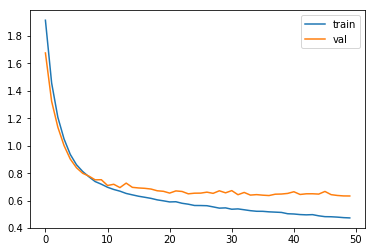

In [25]:
plt.plot(t_losses, label='train')
plt.plot(v_losses, label='val')
plt.legend()

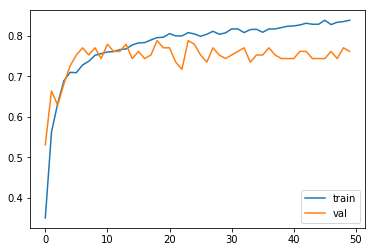

In [26]:
plt.plot(t_accs, label='train')
plt.plot(v_accs, label='val')
plt.legend()

### train adversary

In [27]:
class SenRepsDataset(Dataset):
    '''Rep Dataset'''

    def __init__(self, input_array, class_array):
        """
        Args:
            txt_file (string): Path to the txt file with annotations
            root_dit (string): Directory with all the images
            crop_face (bool): To decide to get the cropped face or full image
            transform (callable, optional): optional transform on a sample
        """
        self.input_array = input_array
        self.targets = class_array
        self.gender_to_class = {'male': 0, 'female': 1}
        
    def __len__(self):
        return len(self.input_array)

    def __getitem__(self, idx):
        row = self.input_array[idx]
        row = torch.from_numpy(row)
        target = torch.tensor(self.gender_to_class[self.targets[idx]])
        return row, target

In [28]:
train_dataset = SenRepsDataset(train_reps, train_gender)
val_dataset = SenRepsDataset(val_reps, val_gender)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [30]:
adversary = ClassNet()

In [31]:
criterion = nn.BCELoss()

In [32]:
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
# scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)

In [33]:
def train_epoch(dataloader, model, opt, criterion):
    model.train()
    losses = AverageMeter()
    acc = AverageMeter()
    
    for batch_idx, (rep, target) in enumerate(dataloader):
        rep = rep.to(device).float()
        target = target.to(device)
        
        output = model(rep)
        
        opt.zero_grad()
        loss = criterion(output.squeeze(), target.float())
        loss.backward()
        opt.step()
        
        losses.update(loss.item(), rep.size(0))
        
#         _, preds = torch.max(output, 1)
        preds = torch.round(output.data).squeeze(1).cpu().numpy()
        c = (preds == target).squeeze()
        accuracy = sum(c).cpu().numpy()/len(target)
        acc.update(accuracy, rep.size(0))
        
        if batch_idx % 20 == 0:
            print('Batch: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {acc.val:.4f} ({acc.avg:.4f})'.format(batch_idx, len(dataloader), loss=losses, acc=acc))
    
    return losses.avg, acc.avg

In [34]:
def validate_epoch(dataloader, model, criterion):
    model.eval()
    losses = AverageMeter()
    acc = AverageMeter()
    
    with torch.no_grad():
        for batch_idx, (rep, target) in enumerate(dataloader):
            rep = rep.to(device).float()
            target = target.to(device)

            output = model(rep)

            loss = criterion(output.squeeze(), target.float())
            
            losses.update(loss.item(), rep.size(0))
#             print(output.squeeze())
#             print(target)
#             _, preds = torch.max(output, 1)
            preds = torch.round(output.data).squeeze(1).cpu().numpy()
#             print(preds)
            c = (preds == target).squeeze()
#             print(c)
            accuracy = sum(c).cpu().numpy()/len(target)
            acc.update(accuracy, rep.size(0))

            if batch_idx % 5 == 0:
                print('Test: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Accuracy {acc.val:.4f} ({acc.avg:.4f})'.format(batch_idx, len(dataloader), loss=losses, acc=acc))

    return losses.avg, acc.avg

In [35]:
t_losses = []
t_accs = []
v_losses = []
v_accs = []
for epoch in range(20):
    print('-'*70)
    print('Epoch: {}'.format(epoch+1))
    train_loss, train_acc = train_epoch(train_loader, adversary, opt_adv, criterion)
    val_loss, val_acc = validate_epoch(val_loader, adversary, criterion)
    print('Avg validation accuracy {}'.format(val_acc))
    t_losses.append(train_loss)
    t_accs.append(train_acc)
    
    v_losses.append(val_loss)
    v_accs.append(val_acc)

----------------------------------------------------------------------
Epoch: 1
Batch: [0/122]	Loss 0.6932 (0.6932)	Accuracy 0.5000 (0.5000)
Batch: [20/122]	Loss 0.6750 (0.6834)	Accuracy 0.8000 (0.7762)
Batch: [40/122]	Loss 0.6641 (0.6744)	Accuracy 0.7000 (0.8171)
Batch: [60/122]	Loss 0.6086 (0.6621)	Accuracy 1.0000 (0.8361)
Batch: [80/122]	Loss 0.5730 (0.6474)	Accuracy 1.0000 (0.8531)
Batch: [100/122]	Loss 0.5098 (0.6335)	Accuracy 1.0000 (0.8564)
Batch: [120/122]	Loss 0.5694 (0.6185)	Accuracy 0.7000 (0.8562)
Test: [0/12]	Loss 0.5790 (0.5790)	Accuracy 0.9000 (0.9000)
Test: [5/12]	Loss 0.5913 (0.5519)	Accuracy 0.8000 (0.8500)
Test: [10/12]	Loss 0.5570 (0.5299)	Accuracy 0.8000 (0.8818)
Avg validation accuracy 0.8849557522123894
----------------------------------------------------------------------
Epoch: 2
Batch: [0/122]	Loss 0.5225 (0.5225)	Accuracy 0.9000 (0.9000)
Batch: [20/122]	Loss 0.4769 (0.4986)	Accuracy 0.9000 (0.8810)
Batch: [40/122]	Loss 0.4552 (0.4802)	Accuracy 0.9000 (0.8780)

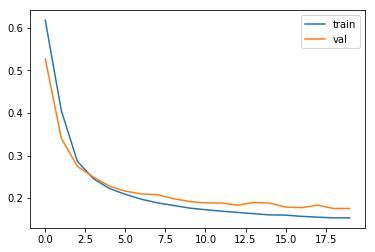

In [36]:
plt.plot(t_losses, label='train')
plt.plot(v_losses, label='val')
plt.legend()

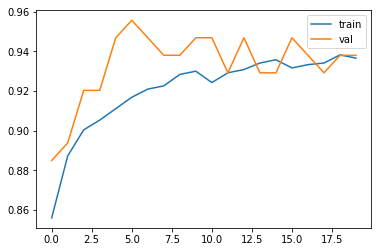

In [37]:
plt.plot(t_accs, label='train')
plt.plot(v_accs, label='val')
plt.legend()